### AABTest Project
The present project is based on an AAB analysis. We have a data base of the user behaviour, separated in three categories, group A, and group A, to compare them in an A/A test and group B 
We have the to analyze the sales funnel, and draw conclusions based on that information. 
the steps we are going to take are: 
1. check the data base and clean them if necesary
2. Do a preliminary analysis to check if there are any anomalies in the data
3. Check the events, number of users, average activity
4. check the event funnel. draw conclusions.
5. check the AB test 

## Data import and initial clean
We import the databbases and then we

In [1]:
from scipy import stats as st
import pandas as pd
from matplotlib import pyplot as plt 
import numpy as np
import math
import seaborn as sns

In [2]:
#Import the dataset
#if downloaded from github use the below line 
#AABTestRaw =  pd.read_csv('logs_exp_us.csv', sep='\s+')

AABTestRaw =  pd.read_csv('/datasets/logs_exp_us.csv', sep='\s+')


In [3]:
# initial visualization 
AABTestRaw.info(show_counts = True)
display (AABTestRaw.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


We don't have any null values, so far, the timestamp is in INT and in seconds so we need to convert that. We also want a column for the date and another for the day hour 

In [4]:
# we change the name of the device and timestamp 

AABTestRaw.rename(columns={'DeviceIDHash': 'DeviceID', 'EventTimestamp': 'EventTime', 'ExpId'
: 'group'}, inplace=True)

#We convert to datetime 
AABTestRaw['EventTime'] = pd.to_datetime(AABTestRaw['EventTime'], unit = 's' )
#We create two new columns one for day and one for hours 

AABTestRaw['Date'] = AABTestRaw['EventTime'].dt.date
AABTestRaw['DayHour'] = AABTestRaw['EventTime'].dt.strftime('%d %H:%M')

AABTestRaw.info(show_counts = True)
display (AABTestRaw.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   EventName  244126 non-null  object        
 1   DeviceID   244126 non-null  int64         
 2   EventTime  244126 non-null  datetime64[ns]
 3   group      244126 non-null  int64         
 4   Date       244126 non-null  object        
 5   DayHour    244126 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 11.2+ MB


,EventName,DeviceID,EventTime,group,Date,DayHour
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25,25 04:43
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25,25 11:11
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,25 11:28
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,25 11:28
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25,25 11:48
5,CartScreenAppear,6217807653094995999,2019-07-25 11:48:43,248,2019-07-25,25 11:48
6,OffersScreenAppear,8351860793733343758,2019-07-25 14:50:42,246,2019-07-25,25 14:50
7,MainScreenAppear,5682100281902512875,2019-07-25 20:14:37,246,2019-07-25,25 20:14
8,MainScreenAppear,1850981295691852772,2019-07-25 20:31:42,247,2019-07-25,25 20:31
9,MainScreenAppear,5407636962369102641,2019-07-26 03:35:12,246,2019-07-26,26 03:35


In [5]:
#we check for duplicates, since we need them to be repeated on three columns to prevent false duplicates ( such as events that 
#happened on the same day but from different devivces) we use the subset of those three columns 
duplicates = AABTestRaw.duplicated(subset=['EventName','DeviceID','EventTime'])
display (duplicates.sum())
#we do have some duplicates so we remove them 
AABTestRaw.drop_duplicates(subset=['EventName','DeviceID','EventTime'],inplace=True )


413

In [6]:
#we check the now cleaned database 
AABTestRaw.info(show_counts = True)
display (AABTestRaw.head(10))

<class 'pandas.core.frame.DataFrame'>
Index: 243713 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   EventName  243713 non-null  object        
 1   DeviceID   243713 non-null  int64         
 2   EventTime  243713 non-null  datetime64[ns]
 3   group      243713 non-null  int64         
 4   Date       243713 non-null  object        
 5   DayHour    243713 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 13.0+ MB


,EventName,DeviceID,EventTime,group,Date,DayHour
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25,25 04:43
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25,25 11:11
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,25 11:28
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,25 11:28
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25,25 11:48
5,CartScreenAppear,6217807653094995999,2019-07-25 11:48:43,248,2019-07-25,25 11:48
6,OffersScreenAppear,8351860793733343758,2019-07-25 14:50:42,246,2019-07-25,25 14:50
7,MainScreenAppear,5682100281902512875,2019-07-25 20:14:37,246,2019-07-25,25 20:14
8,MainScreenAppear,1850981295691852772,2019-07-25 20:31:42,247,2019-07-25,25 20:31
9,MainScreenAppear,5407636962369102641,2019-07-26 03:35:12,246,2019-07-26,26 03:35


We lost 413 data rows from a total 244126 which amounts to less than 0.01 % 

First analysis of the data 
We want to find out the following: 
1. how many events
2. how many users
3. average number of events per user
4. timeframe of the data 


In [7]:
#we clone the data base, if we make any mistakes we can just go back and clone it again. 
AABFirst = AABTestRaw 

In [8]:
# count number of events, users and average number of events per user . 

#events 
Events = AABFirst['EventName'].unique()
display( Events)

#unique users 
UniqueUsersCount = AABFirst['DeviceID'].nunique()
display ("Number of unique users:", UniqueUsersCount)

#Average number of events 
AverageEventsUser = AABFirst.groupby('DeviceID')['EventName'].count().mean()
display("Average number of events per user:", AverageEventsUser)




array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

'Number of unique users:'

7551

'Average number of events per user:'

32.27559263673685

We have five different events, 7551 users and an average of 32 events per users. 
We need to check the funnel of the events to better categorize them 

'Minimum date:'

datetime.date(2019, 7, 25)

'Maximum date:'

datetime.date(2019, 8, 7)

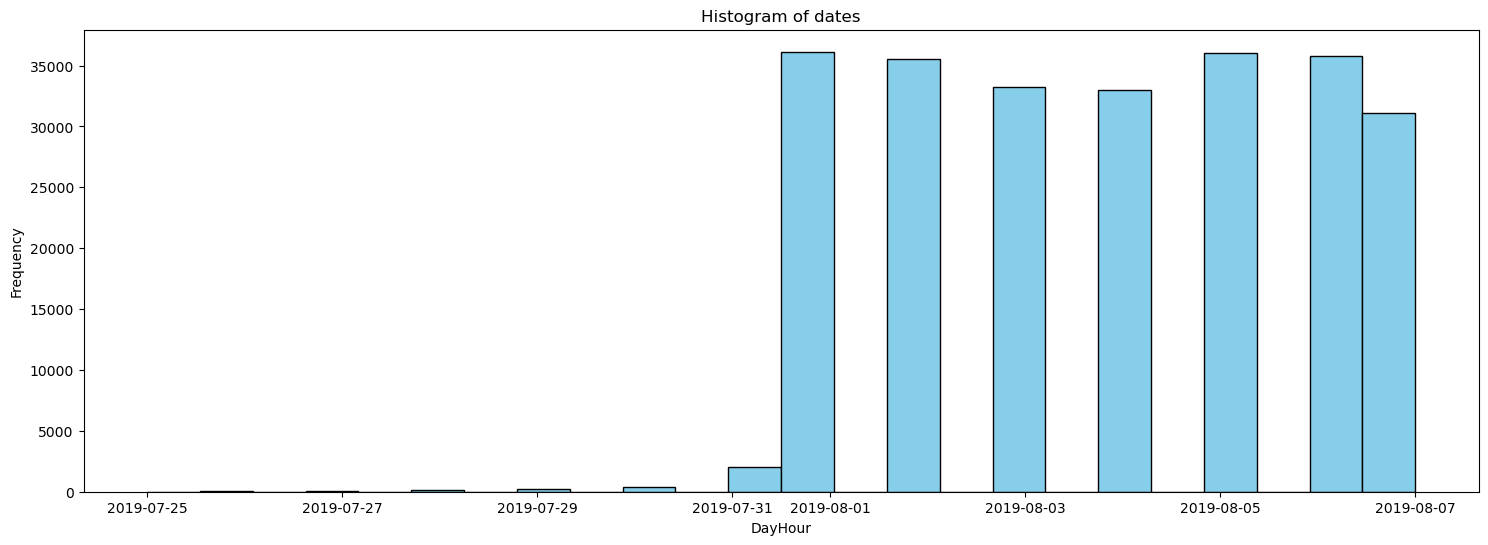

In [9]:
MinDate = AABFirst['Date'].min()
MaxDate = AABFirst['Date'].max()
display("Minimum date:", MinDate)
display ("Maximum date:", MaxDate)

# reate a histogram of Date
plt.figure(figsize=(18, 6))
AABFirst['Date'].hist(bins=24, color='skyblue', edgecolor='black')
plt.title('Histogram of dates')
plt.xlabel('DayHour')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

We see that the data starts being relevant  on the first of august, so we can drop all the data from before that time. 

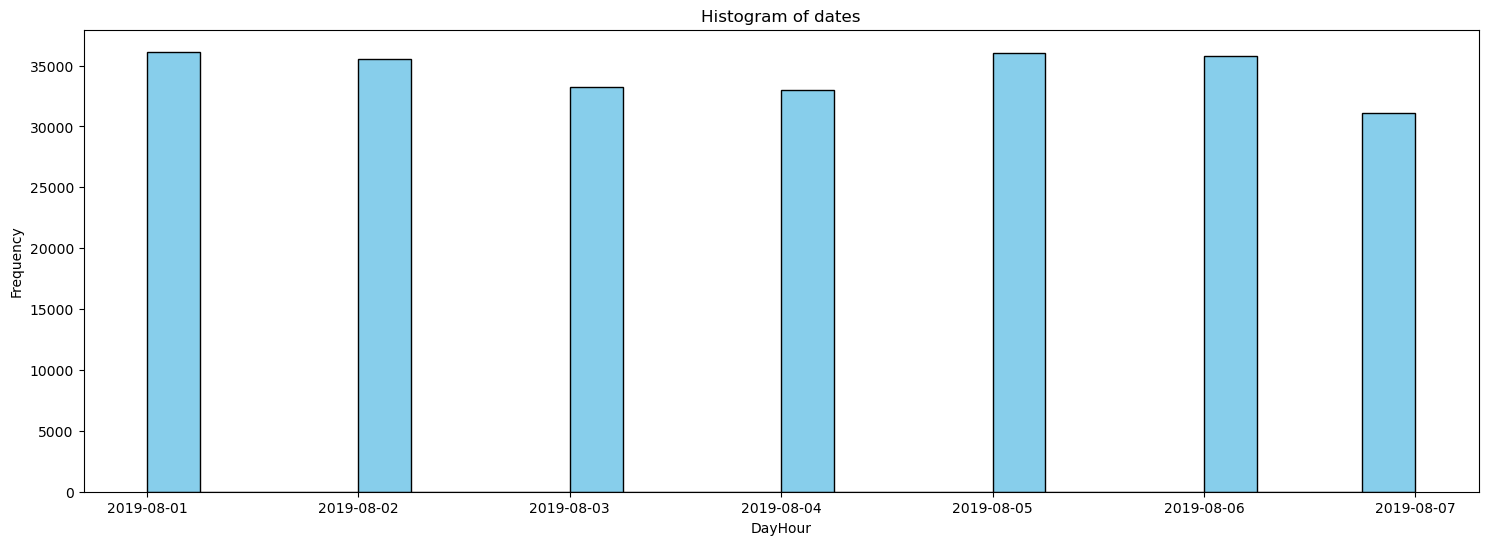

In [10]:
#we drop the data and then visualize again 
AABFirst['Date'] = pd.to_datetime(AABFirst['Date'])
AABCleaned =  AABFirst[AABFirst['Date'] >= '2019-08-01']

plt.figure(figsize=(18, 6))
AABCleaned['Date'].hist(bins=24, color='skyblue', edgecolor='black')
plt.title('Histogram of dates')
plt.xlabel('DayHour')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

We had 244126 and we ended with 240887 so we only loose 3239 data points which amounts to a little over 0.01%. The data is still workable, we only have 7 days of data to compare for the AB tests 

In [11]:
#We verify we have people from each group 
UniquePerGroup = AABCleaned.drop_duplicates(subset=['DeviceID', 'group'])

UniqueUseCounts = UniquePerGroup['group'].value_counts()

display (UniqueUseCounts)

group
248    2537
247    2513
246    2484
Name: count, dtype: int64

We have aproximately 2500 users per group. 

Now we can start checking for the activity Funnel 



In [12]:
#we uye the cleaned version 
AABCFunnel =AABCleaned
display (AABCFunnel)

,EventName,DeviceID,EventTime,group,Date,DayHour
2828,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01,01 00:07
2829,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01,01 00:08
2830,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01,01 00:08
2831,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01,01 00:08
2832,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01,01 00:08
...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07,07 21:12
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07,07 21:13
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07,07 21:14
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07,07 21:14


EventName
MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: count, dtype: int64

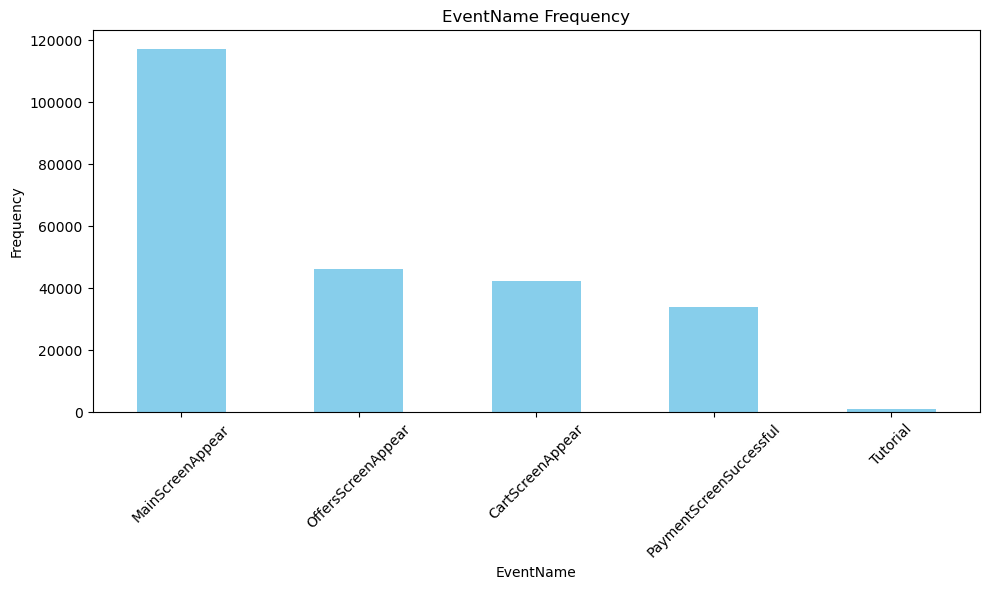

In [13]:
#first we get the events and their frequency 

EventFreq = AABCFunnel['EventName'].value_counts()

display ( EventFreq)
plt.figure(figsize=(10, 6))
EventFreq.plot(kind='bar', color='skyblue')
plt.title('EventName Frequency')
plt.xlabel('EventName')
plt.ylabel('Frequency')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()



EventName
MainScreenAppear           7419
OffersScreenAppear         4593
CartScreenAppear           3734
PaymentScreenSuccessful    3539
Tutorial                    840
Name: DeviceID, dtype: int64

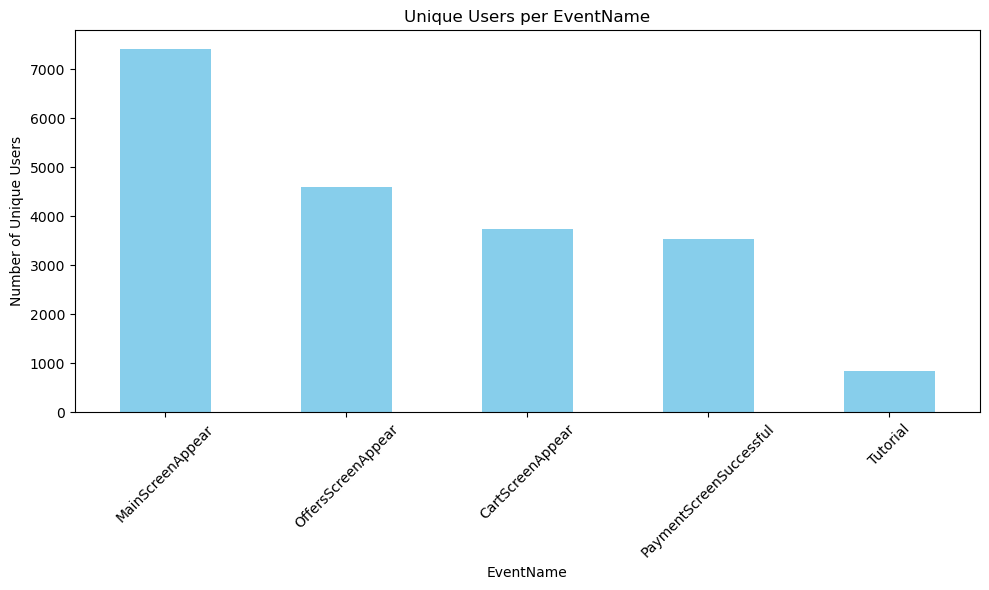

In [14]:
UniqueUsersPerEvent = AABCFunnel.groupby('EventName')['DeviceID'].nunique().sort_values(ascending=False)
display( UniqueUsersPerEvent)

plt.figure(figsize=(10, 6))
UniqueUsersPerEvent.plot(kind='bar', color='skyblue')
plt.title('Unique Users per EventName')
plt.xlabel('EventName')
plt.ylabel('Number of Unique Users')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

Based on the number of unique users per event we can elucidate that the funnel is 
1. Main screen appear > offer screen appear > cartscreen appear>  Payment succesful
The odd one is tutorial but we can infer that not all users use the tutorial so that event is not relevant to the funnel. 
MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

In [15]:
display( UniqueUsersPerEvent)

EventName
MainScreenAppear           7419
OffersScreenAppear         4593
CartScreenAppear           3734
PaymentScreenSuccessful    3539
Tutorial                    840
Name: DeviceID, dtype: int64

In [16]:
firstStep = (UniqueUsersPerEvent['OffersScreenAppear']/UniqueUsersPerEvent['MainScreenAppear'])*100
SecondStep = (UniqueUsersPerEvent['CartScreenAppear']/UniqueUsersPerEvent['OffersScreenAppear'])*100
ThirdStep = (UniqueUsersPerEvent['PaymentScreenSuccessful']/UniqueUsersPerEvent['CartScreenAppear'])*100


display (firstStep)
display (SecondStep)
display (ThirdStep)

61.908613020622724

81.29762682342695

94.7777182645956

analysis
We see that we had 7419 unique visitors. From those 4593 saw the offer and 3734 reached the cart but only 3539 paid. The percentages in each step are:
Visitors to offer : 62% 
retention Offer to cart: 81% 
Cart to paid: 94% 
The point where we lost the most customers was in the mian screen to offer 

Aproximetely 47% of the uses make the full funnel.

## Aqui utilice otro metodo y los resultados salieron diferentes, quisiera entender porque 

In [17]:
#We analyze the funnel step by step 

sales = AABCFunnel.pivot_table(
    index='DeviceID', 
    columns='EventName', 
    values='EventTime',
    aggfunc='min')

step_1 = ~sales['MainScreenAppear'].isna()
step_2 = step_1 & (sales['OffersScreenAppear'] > sales['MainScreenAppear'])

step_3 = step_2 & (sales['CartScreenAppear'] > sales['OffersScreenAppear'])
step_4 = step_3 & (sales['PaymentScreenSuccessful'] > sales['CartScreenAppear']) 

UsersIntheFirstStep = sales[step_1].shape[0]
Noffered = sales[step_2].shape[0]
NcartScreen = sales[step_3].shape[0]
NPayment = sales[step_4].shape[0]

display('Vistiors:', UsersIntheFirstStep)
display('Saw the offer:', Noffered)
display('Saw the cart:', NcartScreen)
display('paid:', NPayment)

'Vistiors:'

7419

'Saw the offer:'

4201

'Saw the cart:'

1767

'paid:'

454

## analysis 
We see that we had 7419 unique visitors. From those 4201 saw the offer and 1767 reached the cart but only 454 paid.
The percentages in each step are: 
Visitors to offer : 56% retention
Offer to cart:  42% 
Cart to paid: 25% 
The point where we lost the most customers was in the cart to final payment 


## AAB Test 
For the AAB test we are going  to check the following:
1. How many users are in each group
2. check any statistical difference between 246 and 247 since those are the A/A group to check if we make a correct separation
3. Check the most popular event, 
4. Compare with the B group 
5. do the statistcial analysis 


In [18]:
AACTests = AABCleaned 

In [19]:
display ( AACTests)

,EventName,DeviceID,EventTime,group,Date,DayHour
2828,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01,01 00:07
2829,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01,01 00:08
2830,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01,01 00:08
2831,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01,01 00:08
2832,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01,01 00:08
...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07,07 21:12
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07,07 21:13
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07,07 21:14
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07,07 21:14


In [20]:
# for the population we use the same code as before 

UniquePerGroup = AACTests.drop_duplicates(subset=['DeviceID', 'group'])

UniqueUseCounts = UniquePerGroup['group'].value_counts()

display (UniqueUseCounts)


group
248    2537
247    2513
246    2484
Name: count, dtype: int64

We now create a funciton to compare how did the behaviour compares in each case 

In [21]:
def GroupBehavour(df, Events ):


    # Filter to only the events  
    RelevantEvent = df[df['EventName'].isin(events )]
    
    # group by group  and device so only unique uses are counted
    EventCounts = RelevantEvent.groupby(['group', 'EventName'])['DeviceID'].nunique().unstack(fill_value=0)
    #we make sure the columns correspond to the funnel to ease the analysis 
    EventCounts = EventCounts.reindex(columns=events, fill_value=0)
    return EventCounts


events = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']
EventsPerGroup = GroupBehavour(AACTests, events)


display (EventsPerGroup)

EventName,MainScreenAppear,OffersScreenAppear,CartScreenAppear,PaymentScreenSuccessful
group,,,,
246,2450,1542,1266,1200
247,2476,1520,1238,1158
248,2493,1531,1230,1181


In [26]:
# we want to know if two populations are equal or not, so we use the MannWithney u test 

def StatAnalysis(df, group1, group2):

    # Create a dictionary for results 
    results = {}


    for event in df.columns:
        
       
        results = st.mannwhitneyu(df.loc[group1, event], df.loc[group2, event])
        display ('p-value: ', results.pvalue)
        alpha = .05
        display ('Para el evento',event)

        if (results.pvalue < alpha):
            display ("Hipótesis nula rechazada: existen diferencias significativas entre las distribuciones de los dos grupos comparados")
        else:
            display ("No se pudo rechazar la hipótesis nula: no podemos sacar conclusiones sobre la diferencia")


    return 
#probamos con la prueba A/A
#we try with the A/A test 
group1 = 246
group2 = 247

results = StatAnalysis(EventsPerGroup, group1, group2)




'p-value: '

1.0

'Para el evento'

'MainScreenAppear'

'No se pudo rechazar la hipótesis nula: no podemos sacar conclusiones sobre la diferencia'

'p-value: '

1.0

'Para el evento'

'OffersScreenAppear'

'No se pudo rechazar la hipótesis nula: no podemos sacar conclusiones sobre la diferencia'

'p-value: '

1.0

'Para el evento'

'CartScreenAppear'

'No se pudo rechazar la hipótesis nula: no podemos sacar conclusiones sobre la diferencia'

'p-value: '

1.0

'Para el evento'

'PaymentScreenSuccessful'

'No se pudo rechazar la hipótesis nula: no podemos sacar conclusiones sobre la diferencia'

We can see that the two control groups, 246 and 247 are very close and have almost not any significant difference. 

In [27]:
#we try with the A/B data 
groupControl = 246
groupExperiment = 248

resultsAB = StatAnalysis(EventsPerGroup, groupControl, groupExperiment)


'p-value: '

1.0

'Para el evento'

'MainScreenAppear'

'No se pudo rechazar la hipótesis nula: no podemos sacar conclusiones sobre la diferencia'

'p-value: '

1.0

'Para el evento'

'OffersScreenAppear'

'No se pudo rechazar la hipótesis nula: no podemos sacar conclusiones sobre la diferencia'

'p-value: '

1.0

'Para el evento'

'CartScreenAppear'

'No se pudo rechazar la hipótesis nula: no podemos sacar conclusiones sobre la diferencia'

'p-value: '

1.0

'Para el evento'

'PaymentScreenSuccessful'

'No se pudo rechazar la hipótesis nula: no podemos sacar conclusiones sobre la diferencia'

Conclusions
🔍 Summary of key findings: The objective of the A/B test was to see if there was any difference with the new letter style. The populations are similar in both A/A/B. Nevertheles when comparing the results and the conversions the behaviour of the users and conversion rates is very similar with no statistcal significance. 


🎯 Relation to the initial objectives: The analysis answered the questions presented.

🚀 Suggestions and recommendations: The letter style didn't change in a relevant way the behaviour of the people. 

The company needs to stop the test and change its approach as the current version does not present any advantage or difference 
📝 Final thoughts :

The project offered a funnel A/B test where there were 5 different events to test and compare, the populations needed to be tested individually to see any significant difference.  


Conclusiones 🔍 Resumen de los Hallazgos Clave: El objetivo del proyeto era probar si habia una diferencia al cambiar las fuentes en el app. Las poblaciones fueron similares tanto en numeros, como en comportamientos, al grado que no hubo una diferencia significativa en los resultados. 


El proyecto ofrecio una prueba donde el aun comparando grupos A con B y haciendo un embudo de trabajo el resultado fue neutro. 

P-value for MainScreenAppear: 1.0
P-value for OffersScreenAppear: 1.0
P-value for CartScreenAppear: 1.0
P-value for PaymentScreenSuccessful: 1.0
